In [1]:
import sys
sys.path.append("..")

import warnings
from pathlib import Path
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from nilearn import signal

from sklearn.covariance import GraphicalLassoCV
from sklearn.pipeline import Pipeline

from nilearn.interfaces.fmriprep import load_confounds
from nilearn import plotting
from nilearn.connectome import GroupSparseCovariance, GroupSparseCovarianceCV

from bold_dementia.data.memento import Memento, MementoTS
from bold_dementia.data.phenotypes import days_to_onset
from bold_dementia.connectivity.atlases import Atlas
from bold_dementia.connectivity.matrices import plot_matrices


CACHE_DIR = "/georges/memento/BIDS/derivatives/schaeffer/"
#CACHE_DIR = None

if CACHE_DIR is None:
    BIDSDIR = Path("/georges/memento/BIDS")
    PPATH = Path("/bigdata/jlegrand/data/Memento/output/augmented_phenotypes.csv")

confounds_strategy = {
    "strategy": ["high_pass", "motion", "wm_csf"],
    "motion": "basic",
    "wm_csf": "basic"
}
SOFT = False
ATLAS = "schaeffer"


/homes_unix/jlegrand/miniconda3/envs/memento/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


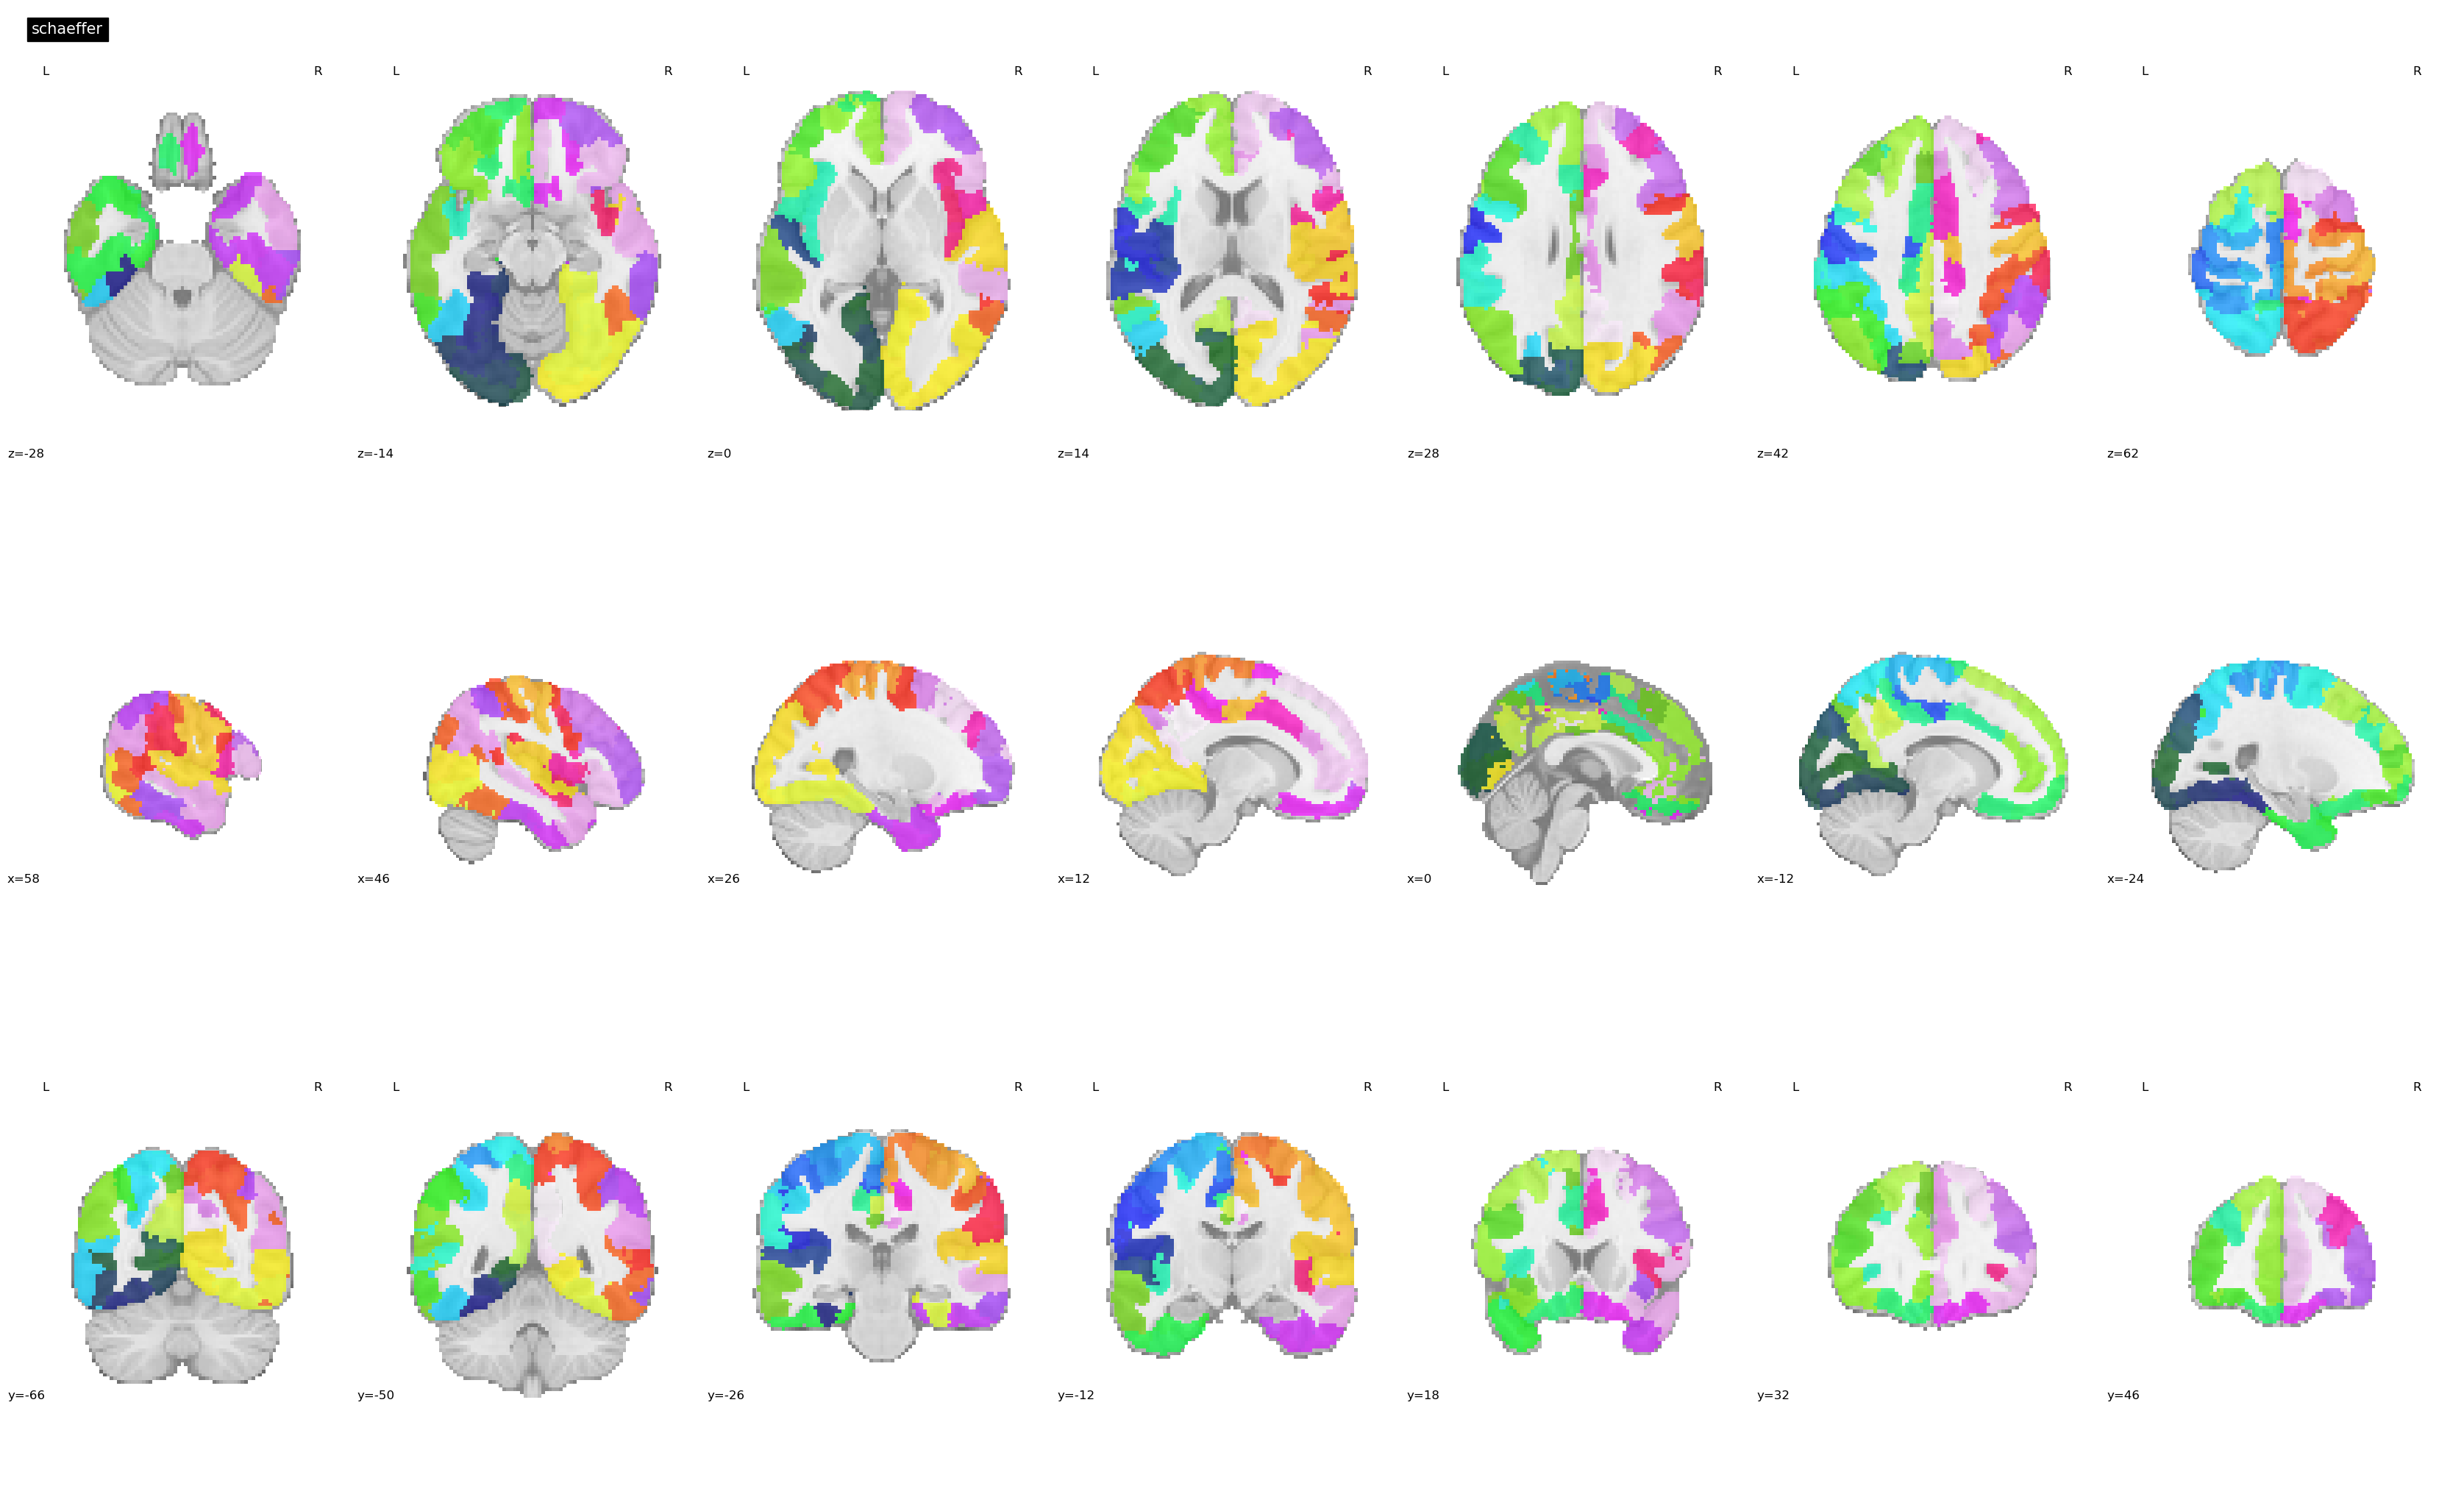

In [93]:
atlas = Atlas.from_name(ATLAS, soft=SOFT)
atlas.plot(display_mode="mosaic")
plotting.show()

In [3]:
def days_to_onset(row):
    return row.scan_to_onset

if CACHE_DIR:
    memento = MementoTS(cache_dir=CACHE_DIR, target_func=days_to_onset)
else:
    memento = Memento(BIDSDIR, PPATH, atlas)

res = next(iter(memento))
res

(array([[662.8475 , 647.64514, 670.0993 , ..., 877.73083, 882.3985 ,
         913.4702 ],
        [658.8802 , 642.1198 , 660.2319 , ..., 871.4786 , 885.58026,
         910.0192 ],
        [656.66705, 643.5157 , 659.10895, ..., 869.2196 , 884.5311 ,
         900.2189 ],
        ...,
        [659.4836 , 647.7854 , 669.7048 , ..., 872.0773 , 886.2803 ,
         910.8693 ],
        [653.1279 , 647.9702 , 663.46655, ..., 867.3978 , 892.3242 ,
         912.53314],
        [654.3256 , 640.2316 , 662.6041 , ..., 869.99915, 888.7917 ,
         911.5599 ]], dtype=float32),
 nan,
 '/georges/memento/BIDS/derivatives/fmriprep-23.2.0/sub-0001/ses-M000/func/sub-0001_ses-M000_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz')

In [4]:
control_ts = []
AD_ts = []
pre_AD_ts = []

if CACHE_DIR:
    for ts, days, fpath in iter(memento):
        confounds, sample_mask = load_confounds(
            fpath, **confounds_strategy
        )
        with warnings.catch_warnings(action="ignore", category=DeprecationWarning):
            cleaned_ts = signal.clean(
                ts,
                sample_mask=sample_mask,
                confounds=confounds,
                standardize="zscore_sample"
            )
        
        if days <= 0:
            AD_ts.append(cleaned_ts)
        elif math.isnan(days):
            control_ts.append(cleaned_ts)
else:
    rs = memento.rest_dataset
    dement_mask = rs.scan_to_onset <= 0
    subsample = pd.concat([rs[dement_mask].sample(n=5), rs[rs.scan_to_onset.isna()].sample(n=5)])
    masker = atlas.fit_masker()
    for index, subrow in subsample.iterrows():
        print(f"Processing {subrow.file_basename}")
        # Preloading with nib is faster than passing a string path
        # to nilearn
        img = nib.load(subrow.file_path)
        confounds, sample_mask = load_confounds(
            subrow.file_path,
            **confounds_strategy
        )
        ts = masker.transform(img, confounds, sample_mask)
        print(subrow.scan_to_onset)
        if subrow.scan_to_onset <= 0:
            AD_ts.append(ts)
        elif math.isnan(subrow.scan_to_onset):
            control_ts.append(ts)
        else:
            pre_AD_ts.append(ts)

Caching uncomplete, stop iterations


In [76]:
import random
random.seed(1)
control_ts_sub = random.choices(control_ts, k=len(AD_ts))
time_series = AD_ts + control_ts_sub
AD_indices = list(range(len(AD_ts)))
control_indices = list(range(len(AD_ts), len(time_series)))
n = len(time_series)
print(f"Study on {n} subjects")

Study on 52 subjects


In [77]:
from sklearn import covariance
from bold_dementia.models.transformers import ListMixin, Concatenator
from nilearn.connectome import ConnectivityMeasure
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator

class ListScaler(StandardScaler, ListMixin):
    pass


# TODO Refactor with Connectivity measure 
# (if we can still use GroupSparseCovariance as estimator)
# Or maybe give Ledoit Wolf another chance

# The sample correlation matrix with relatively short time series
# is a bad estimate of functionnal connectivity
#pipe = Pipeline(
#    [
#        ("concat", Concatenator()),
#        ("scaler", StandardScaler()),
#        ("cov", covariance.GraphicalLasso(alpha=0.1)),
#    ]
#)
# TODO Add reorganisation layer to put in ConnectivityMeasure format
#pipe = Pipeline(
#    [
#        ("scaler", ListScaler()),
#        ("cov", GroupSparseCovariance(alpha=0.0011)), # alpha found by CV
#    ]
#)
pipe = ConnectivityMeasure(kind="covariance")

# Fit AD and controls together to have a common sparsity pattern,
# but is that a good idea?
c = pipe.fit_transform(time_series)

#class ListWolf(covariance.LedoitWolf, ListMixin):
#    pass
#
#ListWolf().fit_transform_lst(time_series)


In [78]:
import numpy.linalg as npl
from sklearn.utils import Bunch
gcov = Bunch(
    covariances_=c,
    precisions_=npl.inv(c)
)

In [79]:
#gcov = pipe.named_steps["cov"]
AD_cov = gcov.covariances_[AD_indices, :, :].mean(axis=0)
AD_prec = gcov.precisions_[AD_indices, :, :].mean(axis=0)

control_cov = gcov.covariances_[control_indices, :, :].mean(axis=0)
control_prec = gcov.precisions_[control_indices, :, :].mean(axis=0)

In [88]:

# TODO Macro labelling, should be added in atlases?
# TODO all those labels, refactor names
from matplotlib.ticker import FixedLocator

# TODO For clarity : more ticks?
def plot_matrices(cov, prec, title, labels, macro_labels=True):
    """Plot covariance and precision matrices.
    For macro labels only schaeffer has been tested so far
    """
    prec = prec.copy()  # avoid side effects

    # Put zeros on the diagonal, for graph clarity.
    size = prec.shape[0]
    prec[list(range(size)), list(range(size))] = 0
    span = max(abs(prec.min()), abs(prec.max()))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # We want network labels to span over several rows
    if macro_labels:
        networks = np.array(list(map(lambda x: str(x).split("_")[2], labels)))
        n_regions = len(labels)
        labels = None
        sort_index = np.argsort(networks)
        ticks = []
        lbls = []
        prev_label = None
        for i, label in enumerate(networks[sort_index]):
            if label != prev_label:
                ticks.append(i)
                lbls.append(label)
                prev_label = label
                ax1.hlines(i, 0, n_regions, colors="black", linestyles="dotted")
                ax2.hlines(i, 0, n_regions, colors="black", linestyles="dotted")
                ax1.vlines(i, 0, n_regions, colors="black", linestyles="dotted")
                ax2.vlines(i, 0, n_regions, colors="black", linestyles="dotted")

        ticks.append(i + 1)
        
    else:
        sort_index = np.arange(len(prec))

    sns.heatmap(cov[np.ix_(sort_index, sort_index)], ax=ax1, vmin=-1, vmax=1, cmap="seismic")
    sns.heatmap(prec[np.ix_(sort_index, sort_index)], ax=ax2, cmap="seismic", vmin=-span, vmax=span)

    # This is a bit unstatisfying
    if macro_labels:
        ax1.yaxis.set_minor_locator(FixedLocator(ticks))
        ax1.yaxis.set_major_locator(FixedLocator([(t0 + t1) / 2 for t0, t1 in zip(ticks[:-1], ticks[1:])]))
        ax1.xaxis.set_major_locator(FixedLocator([(t0 + t1) / 2 for t0, t1 in zip(ticks[:-1], ticks[1:])]))
        ax1.set_yticklabels(lbls, rotation=0)
        ax1.set_xticklabels(lbls, rotation=30)
    
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

    return fig

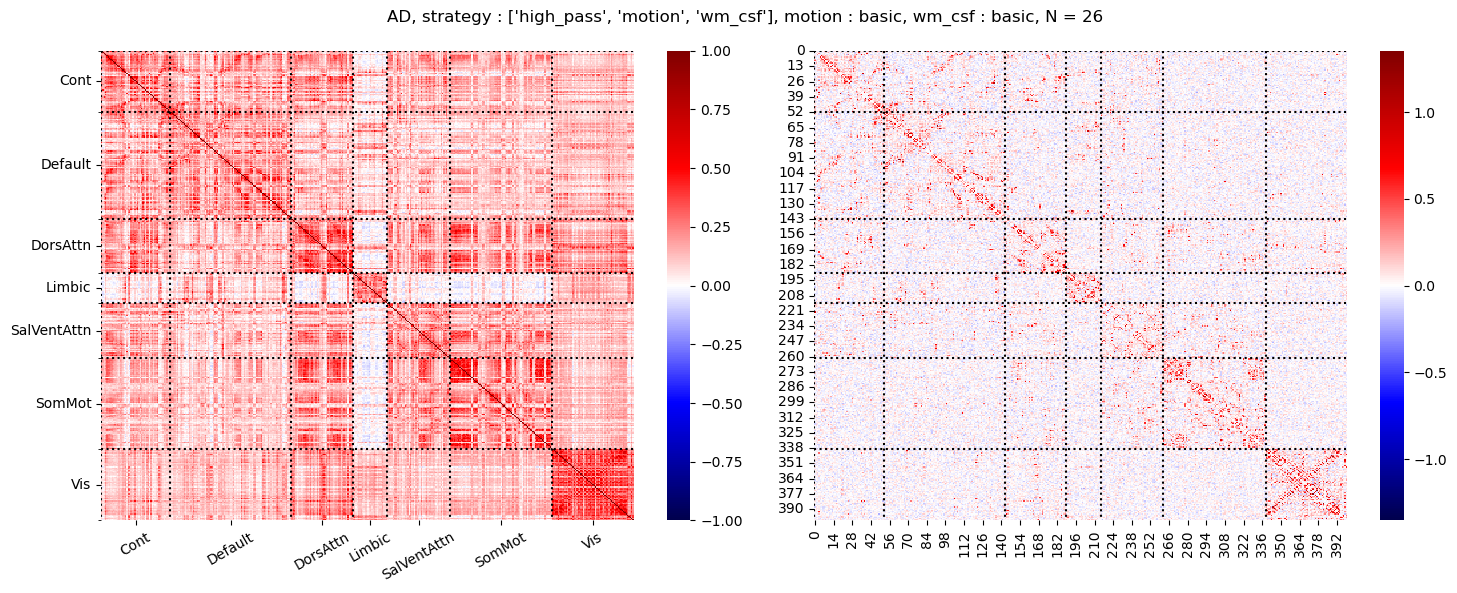

In [89]:
title = ", ".join([f"{k} : {v}" for k, v in confounds_strategy.items()])

# Mean ou pas mean?
plot_matrices(AD_cov, -AD_prec, f"AD, {title}, N = {len(AD_ts)}", atlas.labels, macro_labels=True)

plotting.show()

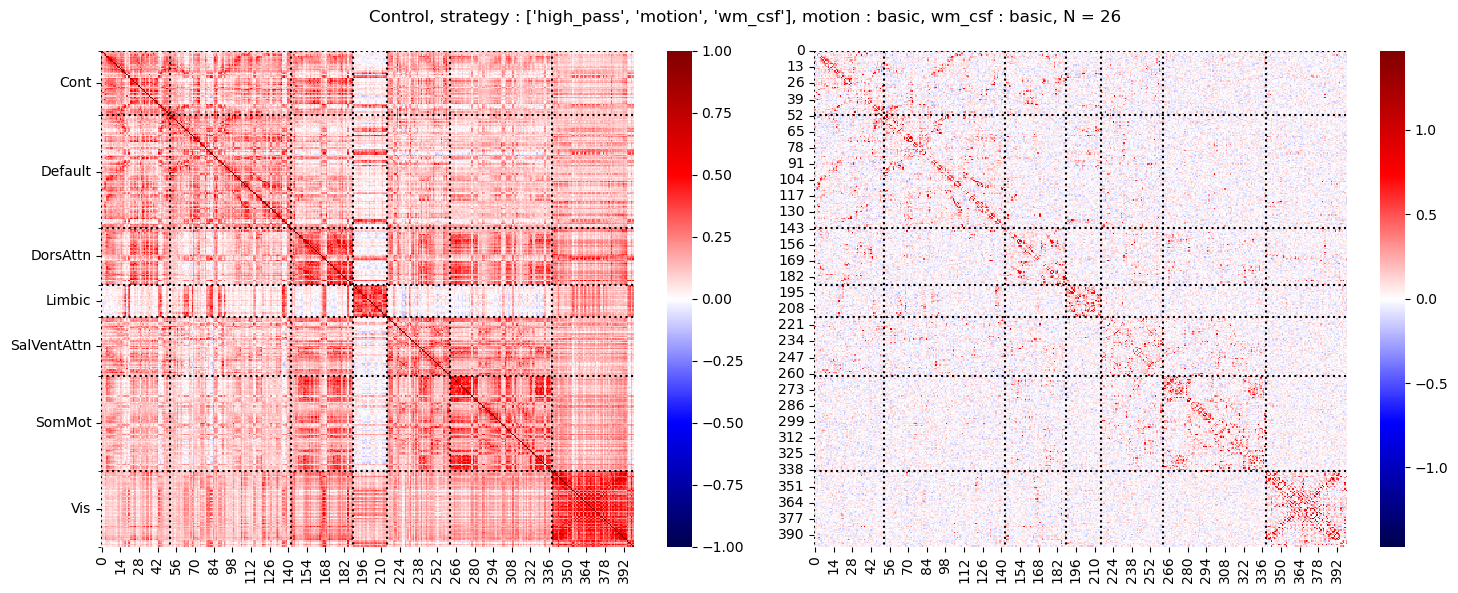

In [82]:
plot_matrices(control_cov, -control_prec, f"Control, {title}, N = {len(control_ts_sub)}", atlas.labels, macro_labels=True)

plotting.show()

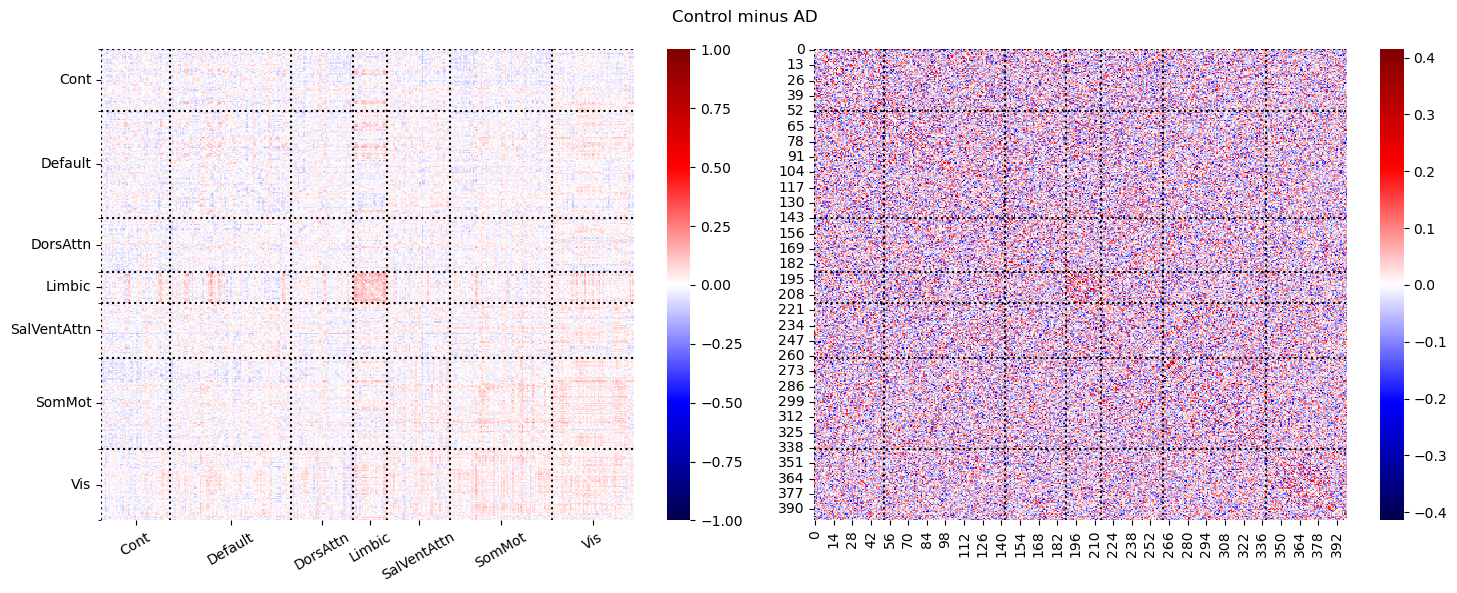

In [90]:
# TODO Same pipeline but shufle time series at the beginning to compare
# TODO Control for age?
plot_matrices(
    control_cov - AD_cov,
    -control_prec + AD_prec,
    "Control minus AD",
    atlas.labels,
    macro_labels=True
)
plotting.show()

In [100]:
diff = control_cov - AD_cov
plt.hist(diff.flatten())
plt.show()
plotting.plot_connectome(diff, atlas.get_coords(), edge_threshold="10%")
plotting.show()